In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# Indlæs data
file_path = "Streamlit/Data/Uddannelse_combined.xlsx"
df = pd.read_excel(file_path)

In [85]:
fuldfort = df[df['Type'] == 'Fuldført']
afbrudt = df[df['Type'] == 'Afbrudt']

years = list(range(2015, 2025))

agg_fuldfort = fuldfort.groupby(['FagLinjer'])[years].sum().reset_index()
agg_afbrudt = afbrudt.groupby(['FagLinjer'])[years].sum().reset_index()

merged = pd.merge(agg_fuldfort, agg_afbrudt, on='FagLinjer', suffixes=('_fuldfort', '_afbrudt'))
merged['Total_fuldfort'] = merged[[f"{y}_fuldfort" for y in years]].sum(axis=1)
merged['Total_afbrudt'] = merged[[f"{y}_afbrudt" for y in years]].sum(axis=1)
merged['Frafaldsrate'] = merged['Total_afbrudt'] / (merged['Total_fuldfort'] + merged['Total_afbrudt'])

In [86]:
features = merged[['Total_fuldfort', 'Total_afbrudt']]
target = merged['Frafaldsrate']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

lr = LinearRegression().fit(X_train, y_train)
tree = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_rf = rf.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Decision Tree R2:", r2_score(y_test, y_pred_tree))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Linear Regression R2: 0.5370723204356667
Decision Tree R2: 0.31244401487125095
Random Forest R2: 0.281920519074897


Linear Regression R² score: 0.5371


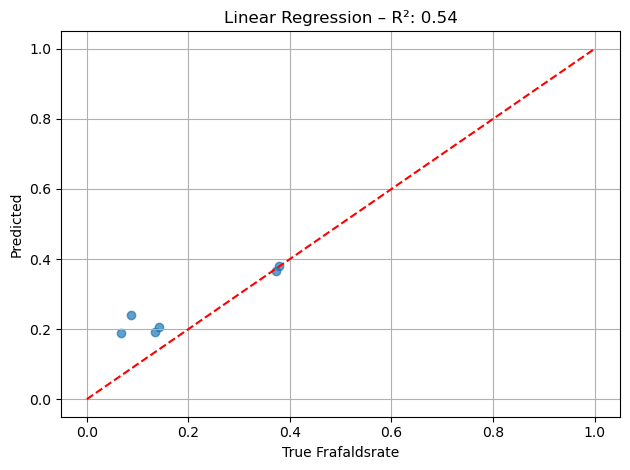

Ridge Regression R² score: 0.5371


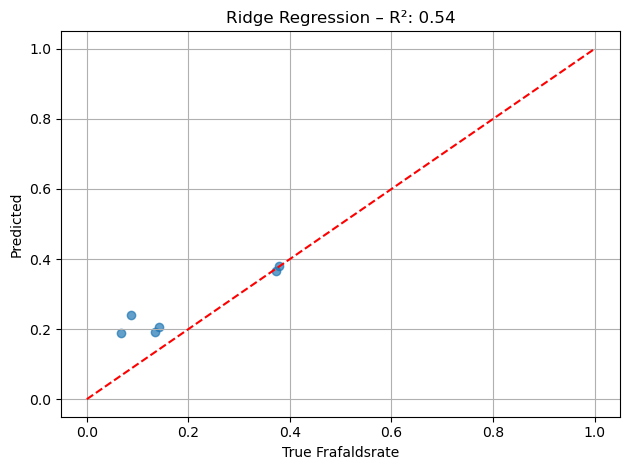

Lasso Regression R² score: 0.5369


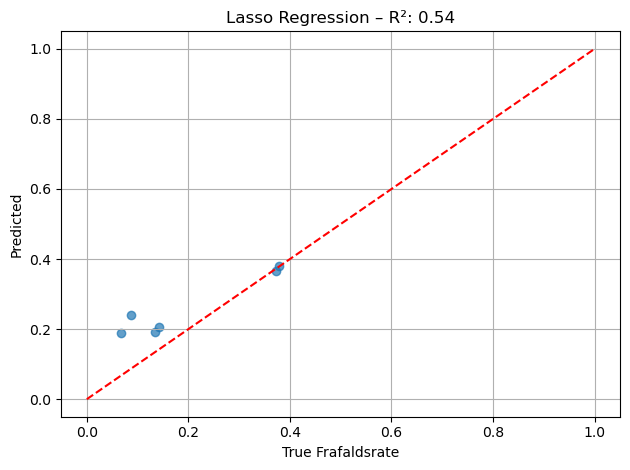

In [87]:
# Supervised Models


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} R² score: {r2:.4f}")
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"{name} – R²: {r2:.2f}")
    plt.xlabel("True Frafaldsrate")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [88]:
X_cluster = merged[['Frafaldsrate']]
X_scaled = StandardScaler().fit_transform(X_cluster)

# KMeans
silhouette_scores = {}
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores[k] = score
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Bedste k:", best_k, "Silhouette Score:", silhouette_scores[best_k])

# PCA
all_years = [f"{y}_fuldfort" for y in years] + [f"{y}_afbrudt" for y in years]
X_pca = StandardScaler().fit_transform(merged[all_years])
pca = PCA(n_components=2)
components = pca.fit_transform(X_pca)
print("PCA Forklaret Varians:", pca.explained_variance_ratio_)

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=2)
labels = db.fit_predict(X_scaled)
n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
print("Antal DBSCAN-klynger:", n_clusters_db)

Bedste k: 2 Silhouette Score: 0.6244253413412766
PCA Forklaret Varians: [0.79407018 0.16999202]
Antal DBSCAN-klynger: 1


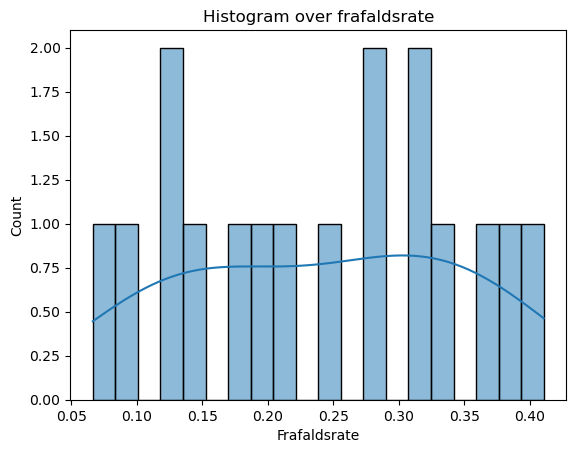

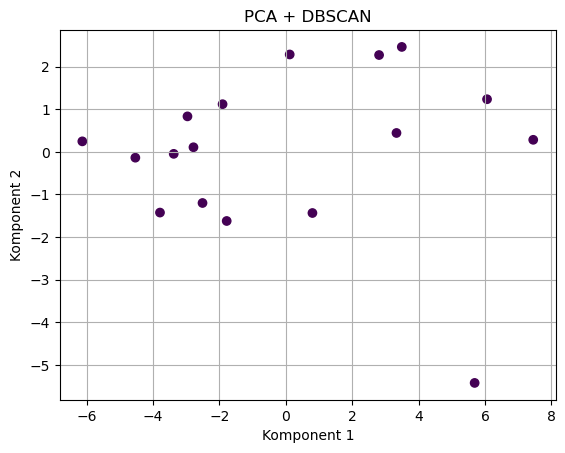

In [89]:
sns.histplot(merged['Frafaldsrate'], bins=20, kde=True)
plt.title("Histogram over frafaldsrate")
plt.show()

plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='viridis')
plt.title("PCA + DBSCAN")
plt.xlabel("Komponent 1")
plt.ylabel("Komponent 2")
plt.grid(True)
plt.show()

In [90]:
years = list(range(2015, 2025))  # Brug kun historiske data til 2024
pivot_df = df.pivot_table(index='FagLinjer', values=years, aggfunc='sum').fillna(0)

X = np.array(years).reshape(-1, 1)  # Features = år
faglinje_predictions = {}

# 3. Træn og forudsig for hver faglinje
for fag, row in pivot_df.iterrows():
    y = row.values
    # Linear Regression
    model = LinearRegression()
    model.fit(X, y)
    pred_2025 = model.predict([[2025]])[0]

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_pred = rf.predict([[2025]])[0]

    faglinje_predictions[fag] = {
        'LR_2025': pred_2025,
        'RF_2025': rf_pred,
        'LR_R2': model.score(X, y),
        'RF_R2': r2_score(y, rf.predict(X))
    }

# 4. Lav dataframe af forudsigelser
pred_df = pd.DataFrame(faglinje_predictions).T
pred_df = pred_df.sort_values(by='RF_2025', ascending=False)

print(pred_df.head(10))

                             LR_2025   RF_2025     LR_R2     RF_R2
Samfund, kandidat       10435.000000  10375.76  0.038705  0.542057
Samfund, bach.          10330.666667  10221.08  0.035898  0.666333
Pædagogik, prof. bach.   9307.466667   9172.16  0.200112  0.882155
Sundhed, prof. bach.     7945.133333   7809.32  0.941573  0.982834
Teknik, prof. bach.      6931.733333   6572.38  0.672007  0.963290
Humaniora, bach.         4337.200000   5307.66  0.954840  0.982404
Humaniora, kandidat      4252.066667   4839.52  0.870682  0.957989
Teknik, kandidat         4904.333333   4655.18  0.841887  0.929921
Natur, bach.             4052.866667   4197.72  0.636622  0.884319
Natur, kandidat          3919.933333   3750.02  0.486632  0.819386


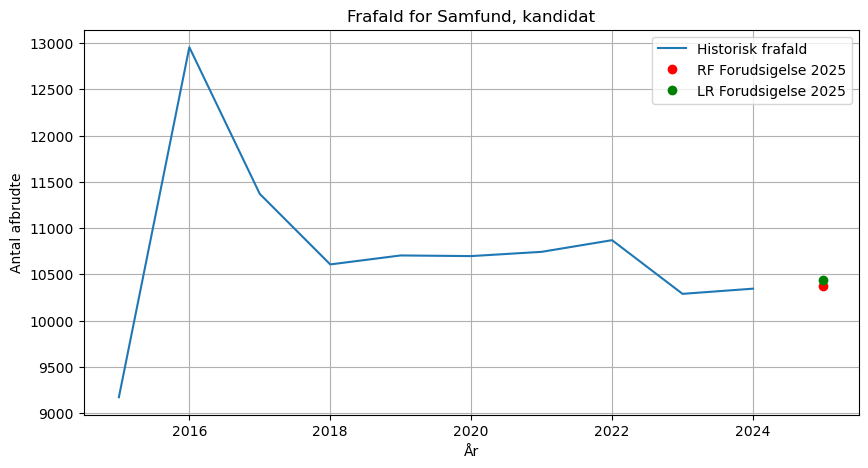

In [91]:
# Eksempel: Plot for én faglinje
fag = pred_df.index[0]
original = pivot_df.loc[fag].values

plt.figure(figsize=(10, 5))
plt.plot(years, original, label="Historisk frafald")
plt.plot(2025, pred_df.loc[fag, 'RF_2025'], 'ro', label="RF Forudsigelse 2025")
plt.plot(2025, pred_df.loc[fag, 'LR_2025'], 'go', label="LR Forudsigelse 2025")
plt.title(f"Frafald for {fag}")
plt.xlabel("År")
plt.ylabel("Antal afbrudte")
plt.legend()
plt.grid(True)
plt.show()


🔢 Samlet forudsagt frafald i 2025
2024 faktisk: 19532 studerende
Random Forest 2025: 84033 studerende (64501, 330.23%)
Linear Regression 2025: 84576 studerende (65044, 333.01%)


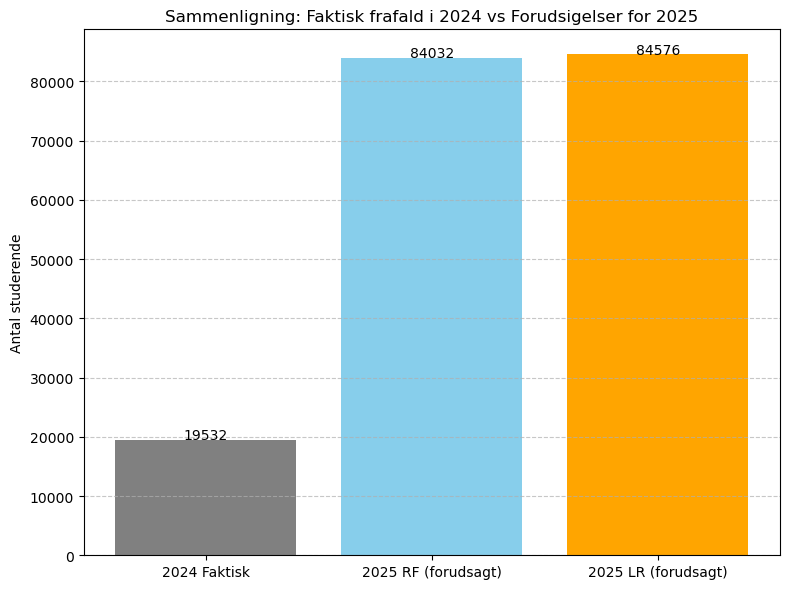

Top 5 faglinjer med største forskelle i forudsigelser (2025):
                     RF_2025  LR_2025  Forskel_2025  Forskel_pct  RF_R2  LR_R2
Humaniora, bach.     5307.66  4337.20        970.46        22.38   0.98   0.95
Humaniora, kandidat  4839.52  4252.07        587.45        13.82   0.96   0.87
Natur, bach.         4197.72  4052.87        144.85         3.57   0.88   0.64
Design, prof. bach.   401.38   396.53          4.85         1.22   0.94   0.73
Sundhed, bach.       2701.28  2737.33        -36.05        -1.32   0.80   0.40


In [92]:
pred_df['Forskel_2025'] = pred_df['RF_2025'] - pred_df['LR_2025']
pred_df['Forskel_pct'] = ((pred_df['RF_2025'] - pred_df['LR_2025']) / pred_df['LR_2025']) * 100
total_rf_2025 = pred_df['RF_2025'].sum()
total_lr_2025 = pred_df['LR_2025'].sum()

# 2. Faktisk samlet frafald i 2024 (fra datasættet)
total_2024 = df[df['Type'] == 'Afbrudt'][2024].sum()

# 3. Forskelle i absolut og procent
diff_rf_abs = total_rf_2025 - total_2024
diff_rf_pct = (diff_rf_abs / total_2024) * 100

diff_lr_abs = total_lr_2025 - total_2024
diff_lr_pct = (diff_lr_abs / total_2024) * 100

# 4. Print oversigt
print("🔢 Samlet forudsagt frafald i 2025")
print(f"2024 faktisk: {total_2024:.0f} studerende")
print(f"Random Forest 2025: {total_rf_2025:.0f} studerende ({diff_rf_abs:.0f}, {diff_rf_pct:.2f}%)")
print(f"Linear Regression 2025: {total_lr_2025:.0f} studerende ({diff_lr_abs:.0f}, {diff_lr_pct:.2f}%)")

# 5. Barplot
plt.figure(figsize=(8,6))
bars = plt.bar(
    ['2024 Faktisk', '2025 RF (forudsagt)', '2025 LR (forudsagt)'],
    [total_2024, total_rf_2025, total_lr_2025],
    color=['gray', 'skyblue', 'orange']
)

# Tilføj tal ovenpå søjlerne
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{int(height)}', ha='center', fontsize=10)

plt.title('Sammenligning: Faktisk frafald i 2024 vs Forudsigelser for 2025')
plt.ylabel('Antal studerende')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Sortér efter største forskel
pred_df_sorted = pred_df.sort_values(by='Forskel_2025', ascending=False)

# 3. Udskriv de 5 største forskelle
print("Top 5 faglinjer med største forskelle i forudsigelser (2025):")
print(pred_df_sorted[['RF_2025', 'LR_2025', 'Forskel_2025', 'Forskel_pct', 'RF_R2', 'LR_R2']].head(5).round(2))
